In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pip install pyyaml h5py  # Required to save models in HDF5 format

In [6]:
# @title # Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Dataset

In [8]:
file_dir = "/content/drive/MyDrive/PU-Y4-S2/Xử lý ngôn ngữ tự nhiên/Midterm/Sentiment_Analysis/IMDB Dataset.csv"


In [9]:
# @title ## Read data
data= pd.read_csv(file_dir)
print("The Shape of the Dataset".format(),data.shape)
data.head()

The Shape of the Dataset (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
# @title ## Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [11]:
# Descriptive statistics
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [12]:
# Identifying missing values
null_values = data.isnull().sum()
null_values

review       0
sentiment    0
dtype: int64

In [13]:
# Identify duplicates
num_duplicates = data.duplicated().sum()
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


## Processing

In [14]:
# @title ### Drop duplicate reviews
review = data['review']
duplicated_review = data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [15]:
# Drop duplicate reviews
data.drop_duplicates(inplace = True)

In [16]:
# Descriptive statistics
data.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


### Clean data

In [17]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [18]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [19]:
# Function to clean data
def clean_text(text,lemmatize = True):
    # Remove html tags
    html_tag=re.compile(r'<.*?>')
    text=html_tag.sub(r'',text)
    # Expanding chatwords and contracts clearing contractions
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    # Remove emoji
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    # Add space after full stop
    text = re.sub(r'\.(?=\S)', '. ',text)
    # Remove urls
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    # Lemmatize or remove stop words
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()])
    return text

In [20]:
# Retain original data
data_copy = data.copy()

In [21]:
# Apply cleaning data
data['review']=data['review'].apply(clean_text,lemmatize = True)

In [22]:
# Converting target variable to numeric labels
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [23]:
# After converting labels
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stunni...,1


## Exploratory data analysis

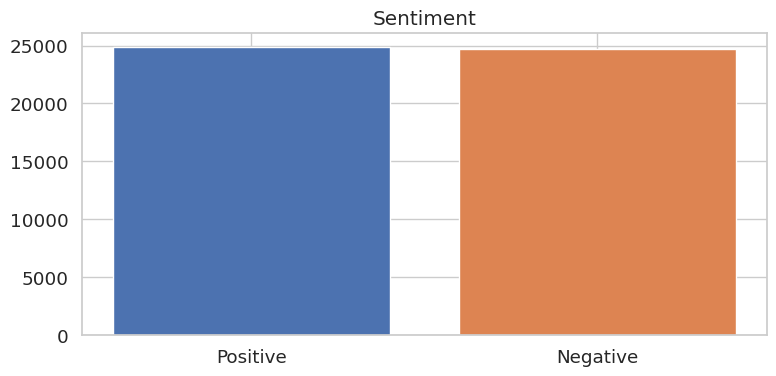

In [24]:
# Count Plot
sns.set(style = "whitegrid" , font_scale = 1.2)
colors = sns.color_palette('deep')
plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=data.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

In [25]:
print('Positive reviews are', (round(data['sentiment'].value_counts()[0])),'i.e.', round(data['sentiment'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative reviews are', (round(data['sentiment'].value_counts()[1])),'i.e.',round(data['sentiment'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive reviews are 24698 i.e. 49.81 % of the dataset
Negative reviews are 24884 i.e. 50.19 % of the dataset


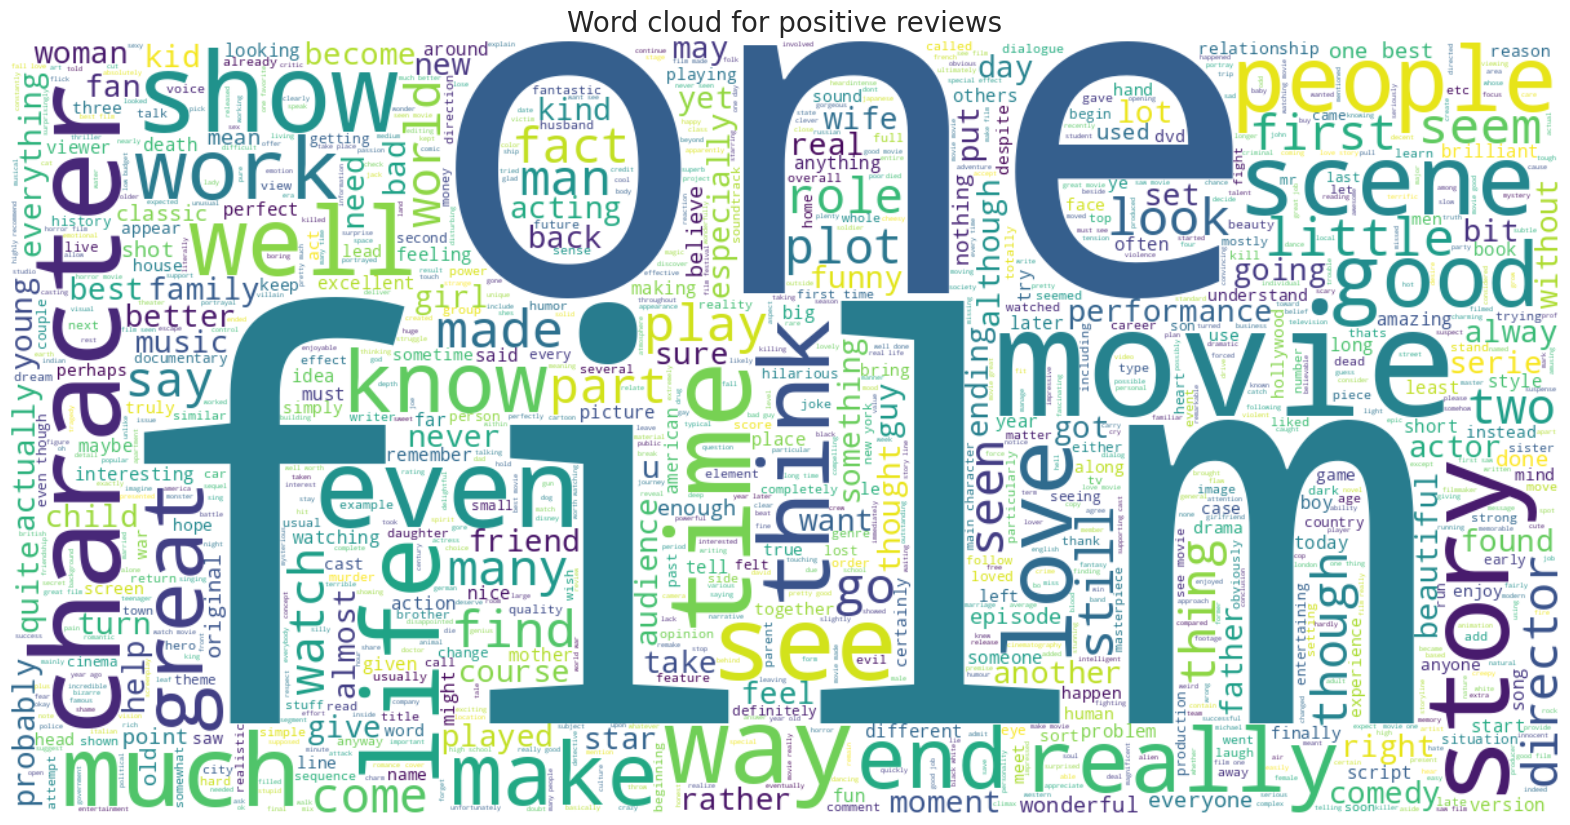

In [26]:
# Word cloud for positive reviews
positive_data = data[data.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

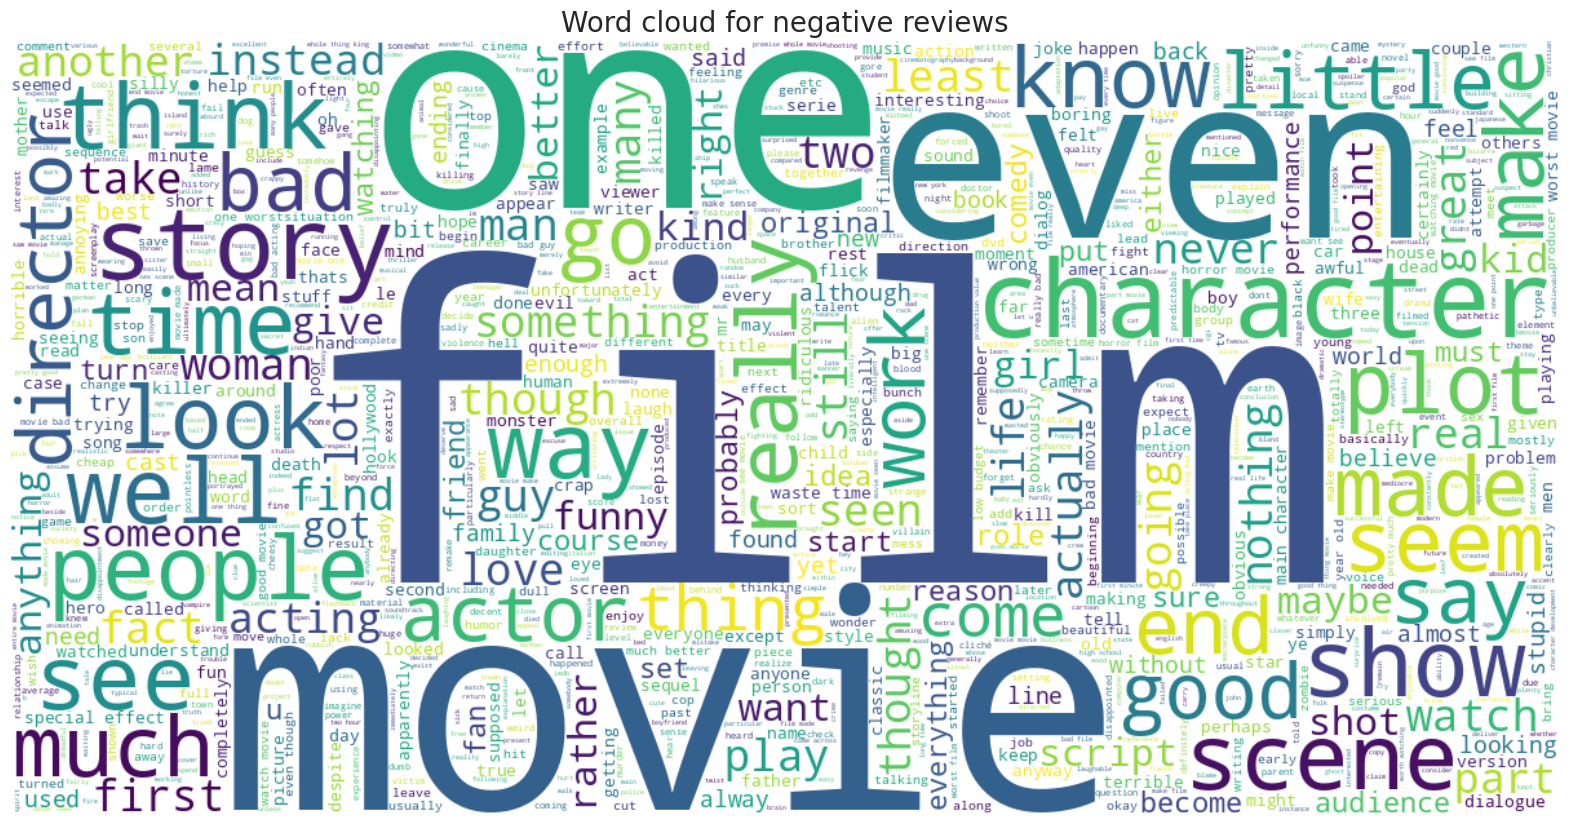

In [27]:
# Word cloud for negative reviews
negative_data = data[data.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

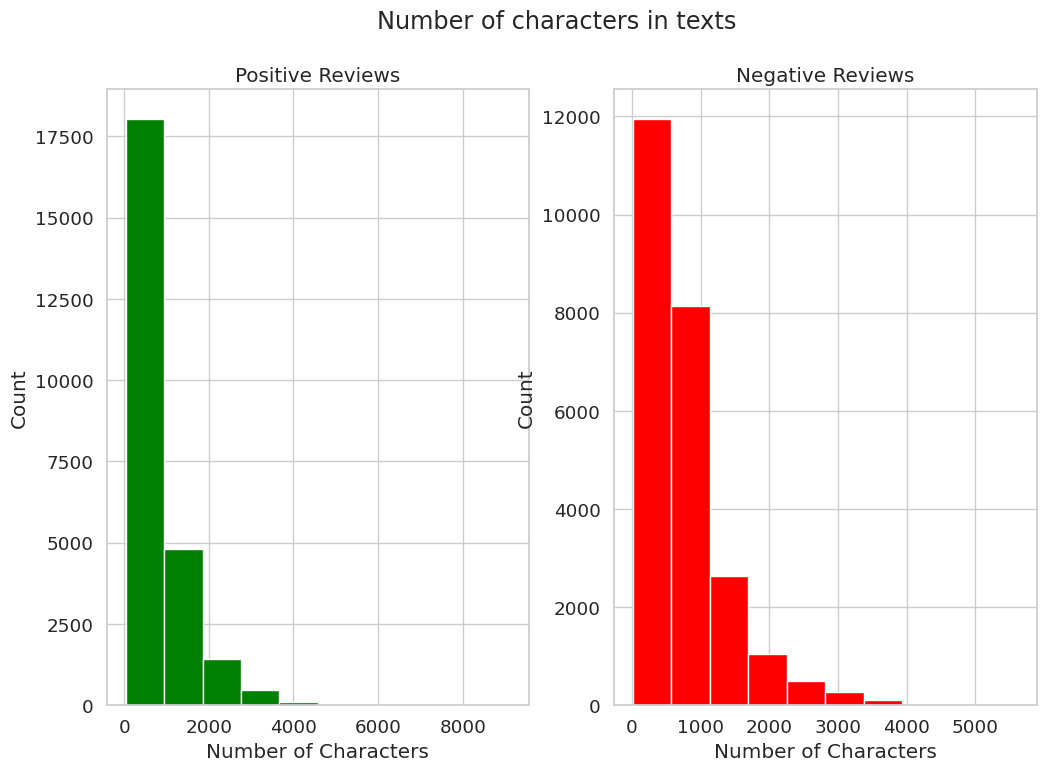

In [28]:
# Number of characters in texts
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()

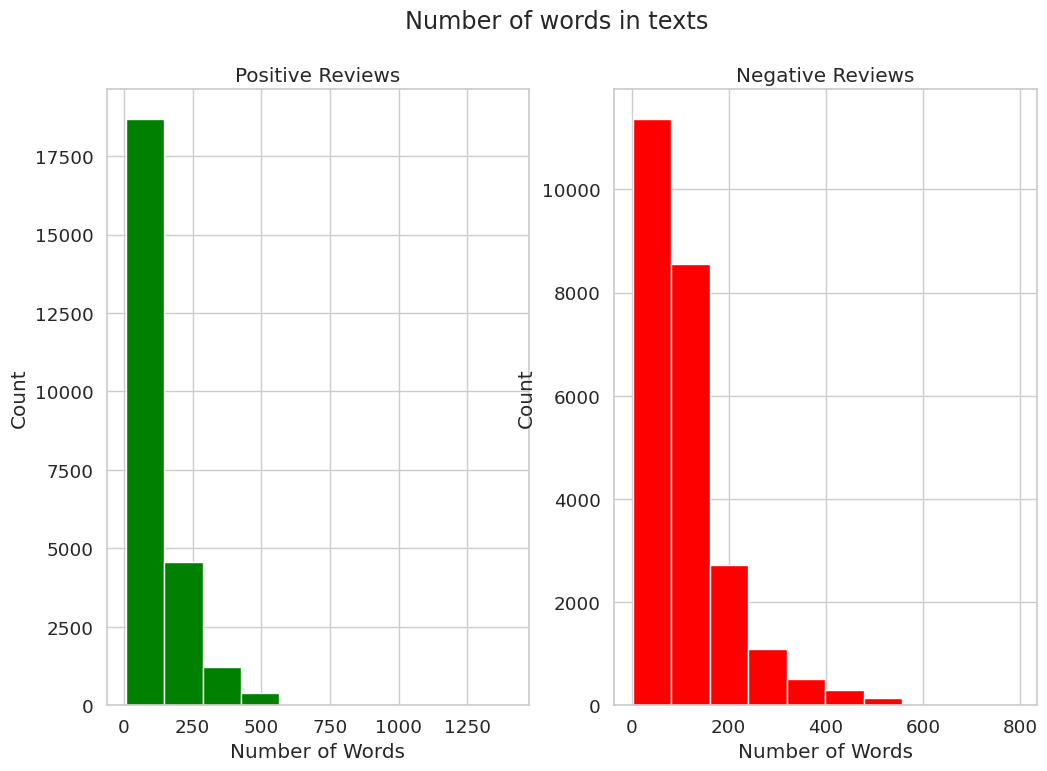

In [29]:
# Number of words in texts
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

In [30]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)
corpus[:5]

['one', 'reviewer', 'mentioned', 'watching', 'oz']

In [31]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,movie,100604
1,film,91130
2,one,53525
3,like,39746
4,time,30090
5,would,30036
6,good,28905
7,character,27801
8,story,24600
9,even,24440


In [32]:
most_common = most_common.sort_values('countv')

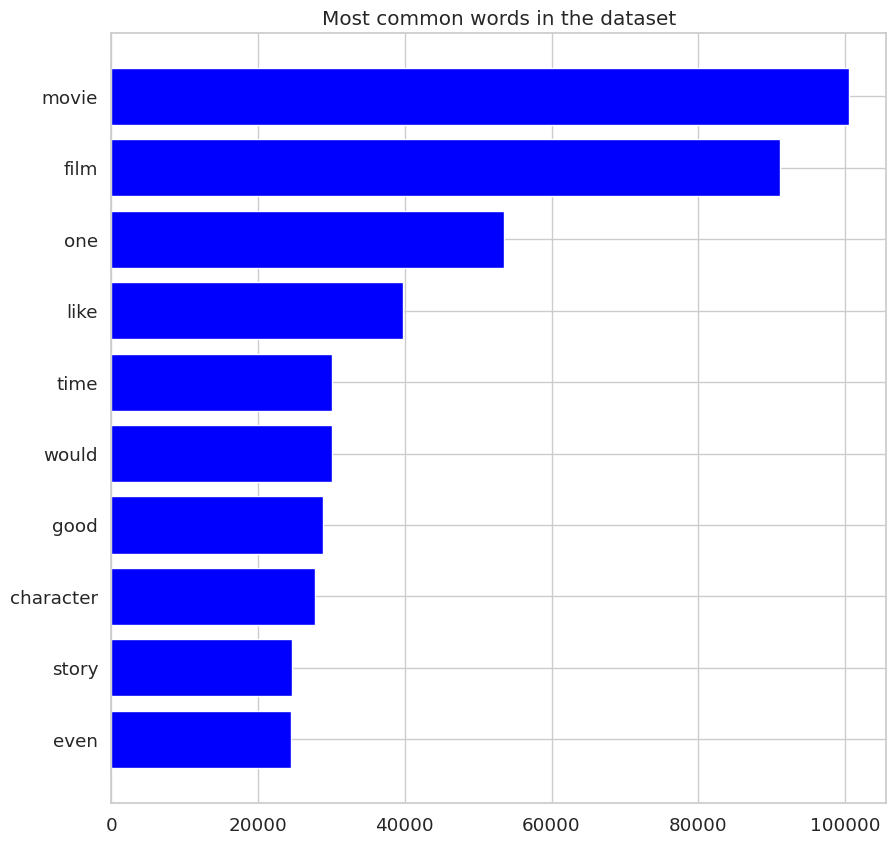

In [33]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

# Predictive Modelling using Machine Learning

In [34]:
# @title ## Splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [35]:
# @title ## Vectorizing data

# tfidfVectorizer
tfidf_vect = TfidfVectorizer()
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)

# # CountVectorizer
# count_vect = CountVectorizer()
# Xtrain_count = count_vect.fit_transform(Xtrain)
# Xtest_count = count_vect.transform(Xtest)

Logistic Regression Accuracy : 89.07%


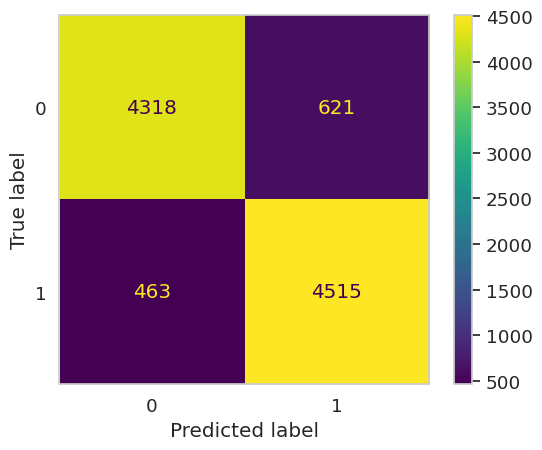

In [36]:
# @title ## Logistic Regression

lr = LogisticRegression()
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))
ConfusionMatrixDisplay.from_estimator(lr, Xtest_tfidf, ytest)
plt.grid(False)
plt.show()


Multinomial Naive Bayes Classifier Accuracy : 86.79%


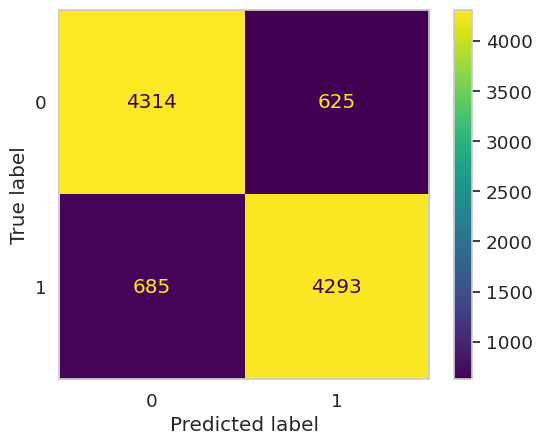

In [37]:
# @title ## Multinomial Naive Bayes

mnb= MultinomialNB()
mnb.fit(Xtrain_tfidf,ytrain)
p2=mnb.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))
ConfusionMatrixDisplay.from_estimator(mnb, Xtest_tfidf, ytest)
plt.grid(False)
plt.show()


XGBoost Accuracy : 84.73%


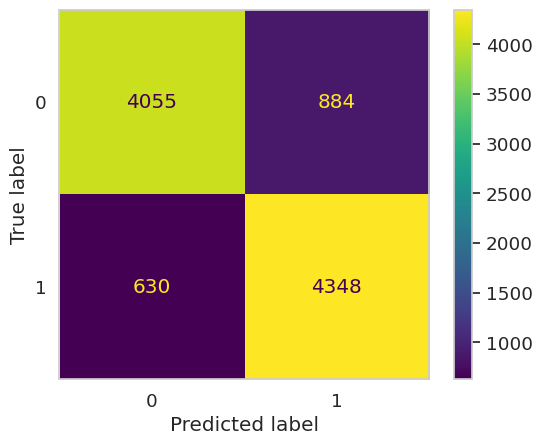

In [38]:
# @title ## XGboost

xgbo = XGBClassifier()
xgbo.fit(Xtrain_tfidf,ytrain)
p4=xgbo.predict(Xtest_tfidf)
s4=accuracy_score(ytest,p4)
print("XGBoost Accuracy :", "{:.2f}%".format(100*s4))
ConfusionMatrixDisplay.from_estimator(xgbo, Xtest_tfidf, ytest)
plt.grid(False)
plt.show()


# Predictive Modelling using Deep Learning


In [39]:
# @title ## Splitting into train and test
data_copy['review']=data_copy['review'].apply(clean_text,lemmatize = False)

# Converting target variable to numerical value
data_copy.sentiment = [ 1 if each == "positive" else 0 for each in data_copy.sentiment]

train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [40]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))

  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

## LSTM

In [41]:
# Set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  136566


In [42]:
# Create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [43]:
# Choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

# If we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1406


In [44]:
# When setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 293


In [45]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.51 % of data


In [46]:
# Create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [47]:
# Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain, test_size=0.2,random_state=10)

In [48]:
def lstm_model(Xtrain, Xval, ytrain, yval, V, D, maxlen, epochs):
    # V: number of words in vocabulary of the dataset
    # D: embedding dims
    # maxlen: maximum length of sequences
    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D, input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_accuracy',
                               mode='min',
                               patience = 2 )
    checkpoints= ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True)
    callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain,
                  validation_data = (Xval,yval),
                  epochs = epochs,
                  verbose = 2,
                  batch_size = 32,
                  callbacks = callbacks)
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])

    return r, model, n_epochs

In [49]:
D = 64 # embedding dims
epochs = 5
r, model_lstm, n_epochs = lstm_model(Xtrain, Xval, ytrain, yval, V, D, max_seq_len, epochs)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 293)]             0         
                                                                 
 embedding (Embedding)       (None, 293, 64)           8740288   
                                                                 
 batch_normalization (Batch  (None, 293, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 293, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 289, 32)           10272     
                                                                 
 dropout_1 (Dropout)         (None, 289, 32)           0         
                                  

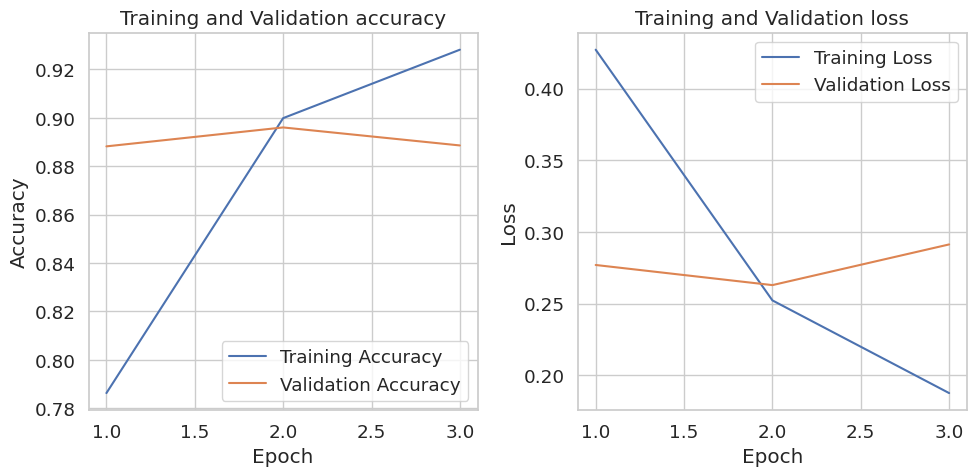

In [50]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [51]:
print("Evaluate Model Performance on Test set")
result = model_lstm.evaluate(pad_test,ytest)
print(dict(zip(model_lstm.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 [==============================] - 3s 9ms/step - loss: 0.3025 - accuracy: 0.8832
{'loss': 0.30251654982566833, 'accuracy': 0.8832308053970337}


310/310 [==============================] - 3s 7ms/step


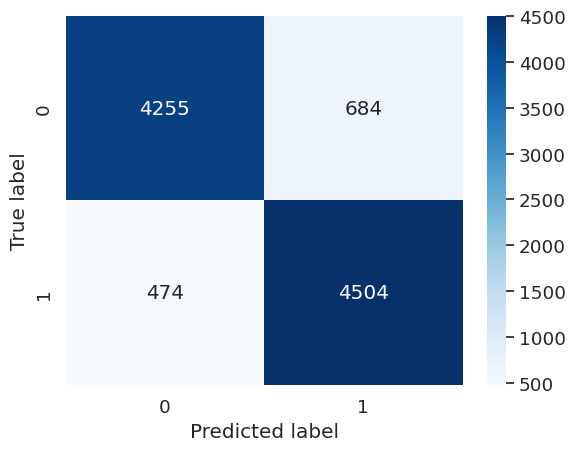

In [52]:
#Generate predictions for the test dataset
ypred = model_lstm.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [53]:
# Save mdel
path_lstm = '/content/drive/MyDrive/PU-Y4-S2/Xử lý ngôn ngữ tự nhiên/Midterm/Sentiment_Analysis/IMDB Model/model_lstm.h5'
model_lstm.save(path_lstm)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## BERT

In [54]:
# @title ### Splitting
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']
# Splitting the train set into train and validation
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain, ytrain, test_size=0.2, random_state=10)

In [55]:
# Perform tokenization
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [56]:
# Pass our texts to the tokenizer.
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object

In [57]:
# Preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [58]:
def bert_model(train_dataset, val_dataset, transformer, max_len, epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_accuracy',
                               mode='min',
                               patience = 2 )
    checkpoints= ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True)
    callbacks = [checkpoints,early_stop]
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs,
                  callbacks = callbacks)
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])

    return r, model, n_epochs

In [59]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [60]:
epochs = 2
max_len = max_seq_len
r, model_bert, n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 293)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 293)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 293, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte          

Epoch 1/2
992/992 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.4983

992/992 [==============================] - 1087s 1s/step - loss: 0.7069 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 2/2
992/992 [==============================] - 326s 328ms/step - loss: 0.6932 - accuracy: 0.5011
Train score: [0.6931561231613159, 0.5011345148086548]
248/248 [==============================] - 82s 330ms/step - loss: 0.6931 - accuracy: 0.5047
Validation score: [0.6931054592132568, 0.5047270655632019]


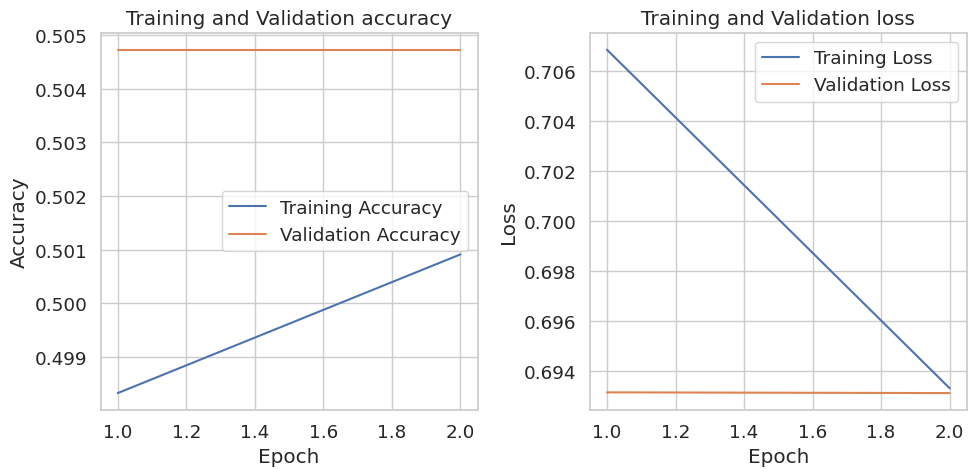

In [61]:
# Plot accuracy and loss
plotLearningCurve(r, n_epochs)

In [62]:
print("Evaluate Model Performance on Test set")
result = model_bert.evaluate(test_dataset.batch(32))
print(dict(zip(model_bert.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 [==============================] - 102s 329ms/step - loss: 0.6931 - accuracy: 0.5020
{'loss': 0.6931434273719788, 'accuracy': 0.5019662976264954}


310/310 [==============================] - 104s 327ms/step


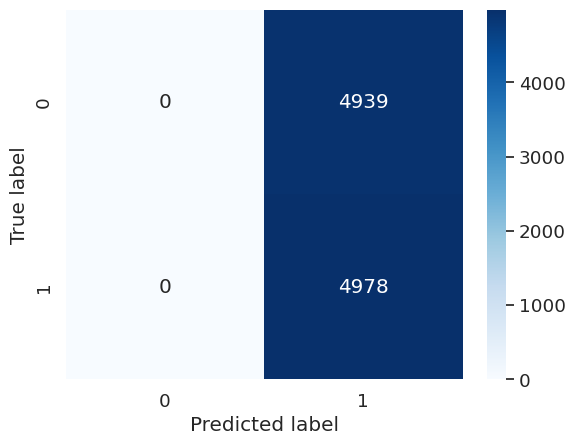

In [63]:
# Generate predictions for the test dataset
ypred = model_bert.predict(test_dataset.batch(32))
ypred = ypred>0.5
# Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [64]:
# Save mdel
path_bert = '/content/drive/MyDrive/PU-Y4-S2/Xử lý ngôn ngữ tự nhiên/Midterm/Sentiment_Analysis/IMDB Model/model_bert.h5'
model_bert.save(path_bert)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
